In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def split_data(data, validation=.7, test=.3):
    if validation + test != 1:
        raise ValueError('Sum  of validation (' + str(validation) + ') and test(' + str(test) + ') is not equal 1')
        
    data = np.asarray(data)
    v = int(len(data) * validation)
    t = int(len(data) * test)
    
    return data[:v], data[-t:]
    


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data_flatten.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.saved_cells_for_validation = []
        self.predict_validation_cells = []
        self.predict_test_cells = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            validation_cells, test_cells = split_data(test_cells)
            self.saved_cells_for_validation.append(validation_cells)
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self, display_cells=None):
        list_of_predict = {}
            
#         if display_cells is None or display_cells > len(self.saved_cells_for_test[0]):
#             display_cells = len(self.saved_cells_for_test[0])
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
#         print("---------------------------------------------------------------------------------------")
        avg_diff_valid = np.zeros(len(self.saved_cells_for_validation))
        for i in range(len(self.saved_cells_for_validation[0])):
            for j in range(len(self.saved_cells_for_validation)):
                idx, val = self.saved_cells_for_validation[j][i]
                idx = int(idx)
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff_valid[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val))
                    
        self.predict_validation_cells = list_of_predict
                    
        list_of_predict = {}
        print("---------------------------------------------------------------------------------------")
        print("VALIDATION: " + str(len(self.saved_cells_for_validation[0])), end="")
        for i in range(len(avg_diff_valid)):
            val = avg_diff_valid[i]*100/len(self.saved_cells_for_validation[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
    
    
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0][:display_cells])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                idx = int(idx)
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
#                 print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
#             print()
        print("---------------------------------------------------------------------------------------")

        print("TEST: " + str(len(self.saved_cells_for_test[0])), end="")
        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        self.predict_test_cells = list_of_predict
#         for i in range(len(list_of_predict)):
#             self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.is_first_iteration),
            steps=100
        )
        
        self.is_first_iteration = False

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_06/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment)+ '_2')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		2.29673% 	6.78342% 	0.04888		0.02526		0.0		0.9846	
(1024,256) 	95.4% 		0.57659% 	6.45741% 	0.82382		0.80182		0.00039		0.90759	
(1024,1024) 	3.04% 		1.94214% 	2.30491% 	0.02452		0.00331		1e-05		0.31963	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
VALIDATION: 700		52.32023%			3.96454%			70.89824%	
---------------------------------------------------------------------------------------
TEST: 300		52.85927%			3.85140%			69.87993%	


(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
2.479372e-10
0.98460174
0.00038511175
0.90758574
1.0556257e-05
0.31963405


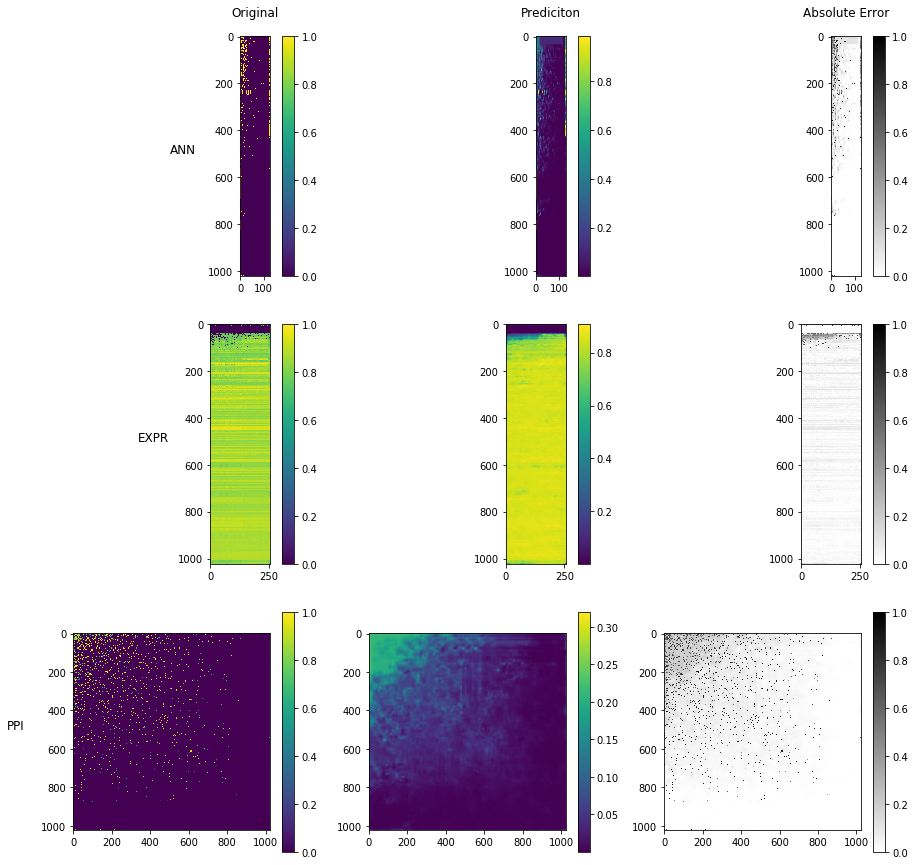

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_06/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;
    
    
cols = ['{}'.format(col) for col in ['Original', 'Prediciton', 'Absolute Error']]
rows = ['{}'.format(row) for row in ['ANN', 'EXPR', 'PPI']]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    
for i in range(len(model.org_data)):
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[i][0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))
    ax.set_ylabel(rows[i], labelpad=25, rotation=0, size='large')
    if i == 0:
        ax.set_title(cols[0], pad=20)

    ax = axes[i][1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))
    if i == 0:
        ax.set_title(cols[1], pad=20)

    ax = axes[i][2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    if i == 0:
        ax.set_title(cols[2], pad=20)
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[i][0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[i][1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[i][2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_org_vs_predict_all.png')

plt.show()


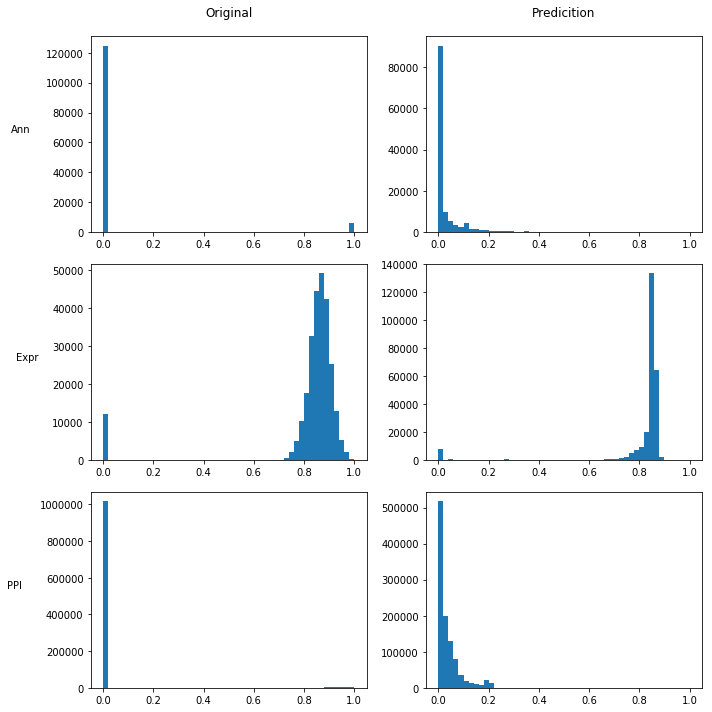

In [6]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'PPI']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, org_data in enumerate(model.org_data):
    org_data = org_data.flatten()
    pred_data = model.predict_data[i].flatten()
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=False, range=(0,1))

    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=False, range=(0,1))
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_data_distribution.png')
plt.show()

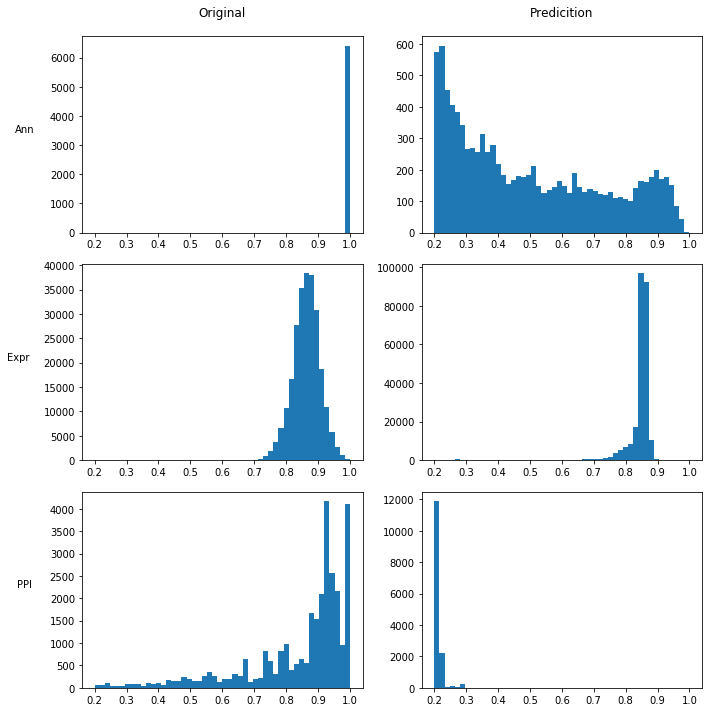

In [9]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['Ann', 'Expr', 'PPI']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, org_data in enumerate(model.org_data):
    
    new_zero = 0.2
    
    org_data = org_data.flatten()
    pred_data = model.predict_data[i].flatten()
    org_data = org_data[org_data > new_zero]
    pred_data = pred_data[pred_data >= new_zero]
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=False, range=(new_zero,1))

    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=False, range=(new_zero,1))
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_data_distribution_zoom_01.png')
plt.show()

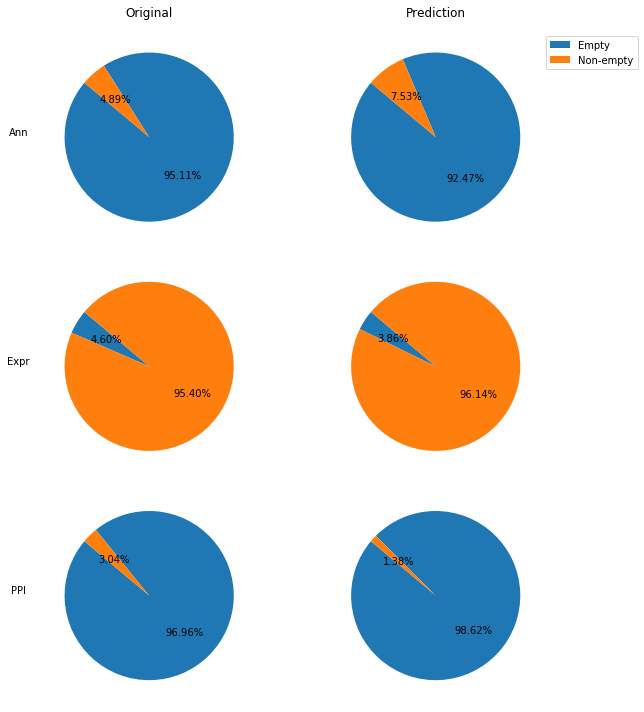

In [10]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Non-empty']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
new_zero = 0.2

for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    
    org_data_zeros = org_data[org_data == 0]
    org_data_nonzeros = org_data[org_data > 0]
    
    pred_data_zeros = pred_data[pred_data < new_zero]
    pred_data_nonzeros = pred_data[pred_data >= new_zero]
    
    ax = axes[i][0]
    ax.pie([len(org_data_zeros), len(org_data_nonzeros)], autopct='%1.2f%%', startangle=140)
    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    if i == 0:
        ax.set_title(cols[0],pad=15)
    
    
    ax = axes[i][1]
    ax.pie([len(pred_data_zeros), len(pred_data_nonzeros)], autopct='%1.2f%%', startangle=140)
    
    if i == 0:
        ax.set_title(cols[1],pad=15)
        ax.legend(bbox_to_anchor=(1, 1.0), labels=labels)
        
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_pie_chart_zoom_01.png')
plt.show()

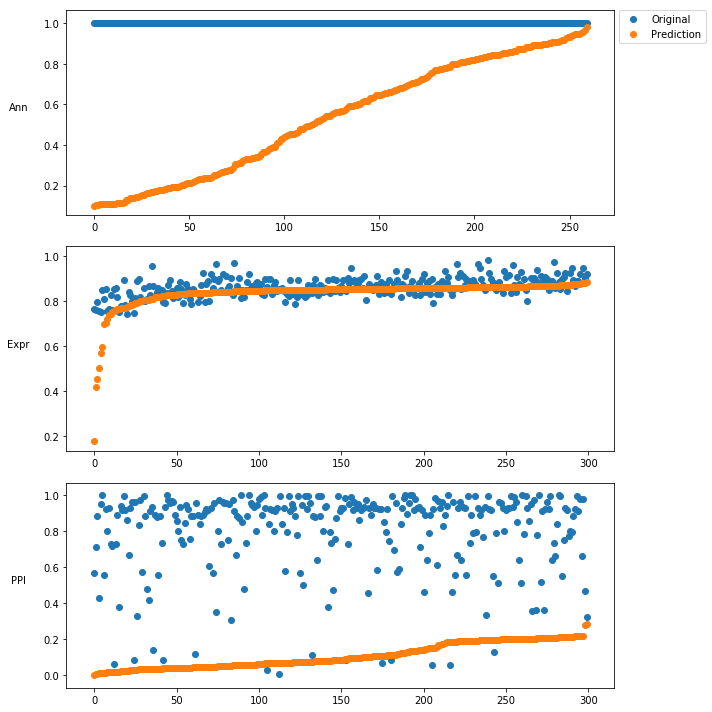

In [18]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Full']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_test_cells[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.1:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.1:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

            
    ax = axes[i]
    data = sorted(data, key=lambda l:l[3])
    for j in range(len(data)):
        data[j][0] = j
        data[j][2] = j
        
    data = np.asarray(data)
    ax.scatter(data[:,0], data[:,1], label='Original')
    ax.scatter(data[:,2], data[:,3], label='Prediction')
    ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1, 1.025))
    
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_test_cells_org_vs_prediction.png')
plt.show()

In [19]:
from builtins import enumerate

print(__doc__)

# from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import KFold
import numpy as np

from skfusion import datasets
from skfusion import fusion as skf

import sys
#sys.path.append('/mag/scripts')
sys.path.append('/home/lpodgorsek/mag/scripts')
import utilityFunctions as uf
import base2
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data

def remove_cells(data, cells):
    row, col = data.shape
    data = data.flatten()
    for cell in cells:
        data[cell[0]] = 0
    
    return data.reshape(row, col)


test_cells_ann = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ann.npz')
test_cells_expr = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_expr.npz')
test_cells_ppi = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ppi.npz')

dicty = datasets.load_dicty()
gene = dicty.get_object_type("Gene")
go_term = dicty.get_object_type("GO term")
exp_cond = dicty.get_object_type("Experimental condition")

dicty[gene][go_term][0].data = base2.resize_rows_and_columns_data(dicty[gene][go_term][0].data, 2)
dicty[gene][exp_cond][0].data = base2.resize_rows_and_columns_data(dicty[gene][exp_cond][0].data, 2)
dicty[gene][gene][0].data = base2.resize_rows_and_columns_data(dicty[gene][gene][0].data, 2)

dicty[gene][go_term][0].data = uf.normalization(dicty[gene][go_term][0].data)
dicty[gene][exp_cond][0].data = uf.normalization(dicty[gene][exp_cond][0].data)
dicty[gene][gene][0].data = uf.normalization(dicty[gene][gene][0].data)

dicty[gene][go_term][0].data = uf.order_by_clustering(dicty[gene][go_term][0].data, 'single')
dicty[gene][exp_cond][0].data = uf.order_by_clustering(dicty[gene][exp_cond][0].data, 'single')
dicty[gene][gene][0].data = uf.order_by_clustering(dicty[gene][gene][0].data, 'single')

dicty[gene][go_term][0].data = remove_cells(dicty[gene][go_term][0].data, test_cells_ann)
dicty[gene][exp_cond][0].data = remove_cells(dicty[gene][exp_cond][0].data, test_cells_expr)
dicty[gene][gene][0].data = remove_cells(dicty[gene][gene][0].data, test_cells_ppi)


n_folds = 10
n_genes = dicty[gene][go_term][0].data.shape[0]

kfold = KFold(n_splits=n_folds)
fold_mse = np.zeros(n_folds)
ann_mask = np.zeros_like(dicty[gene][go_term][0].data).astype('bool')

relations = [
    skf.Relation(dicty[gene][go_term][0].data, gene, go_term),
    skf.Relation(dicty[gene][exp_cond][0].data, gene, exp_cond),
    skf.Relation(dicty[gene][gene][0].data, gene, gene)]
fusion_graph = skf.FusionGraph(relations)
fuser = skf.Dfmc(max_iter=30, n_run=1, init_type='random', random_state=0)


org_data_DFMF = dicty[gene][go_term][0].data
predict_DFMF = np.empty((0, 128))

data_idx = [x for x in range(n_genes)]
for i, (train_idx, test_idx) in enumerate(kfold.split(data_idx)):
    ann_mask[:] = False
    ann_mask[test_idx, :] = True
    fusion_graph[gene][go_term][0].mask = ann_mask
    

    fuser.fuse(fusion_graph)
    pred_ann = fuser.complete(fuser.fusion_graph[gene][go_term][0])[test_idx]
    true_ann = dicty[gene][go_term][0].data[test_idx]
    fold_mse[i] = metrics.mean_squared_error(pred_ann, true_ann)
    predict_DFMF = np.r_[predict_DFMF, pred_ann]

print("MSE: %5.4f" % np.mean(fold_mse))

test_cells = load_test_cells('/home/lpodgorsek/data/cnn/dicty/_00/samples_ann.npz')
predict_cells = []
org_cells = []
# test_cells = test_cells[:10]

avg_diff = 0
predict_data = predict_DFMF.flatten()
print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
print("---------------------------------------------------------------------------------------")
for i in range(len(test_cells)):
    org_val = test_cells[i][1]
    predict_val = predict_data[test_cells[i][0]]
    diff_abs = np.abs(org_val - predict_val)
#     print(str(test_cells[i]) + ' ' + format(predict_val, '.5f') + ' ' + format(org_val, '.5f') + ' ' + format(diff_abs, '.5f') )
    
    avg_diff += diff_abs
    org_cells.append([test_cells[i][0], test_cells[i][1]])
    predict_cells.append([test_cells[i][0], predict_val])
    

# print()
# print("---------------------------------------------------------------------------------------")

val = avg_diff*100/len(test_cells)
print("\t\t" + format(val, '.5f') + "%", end="\t")
print()

Automatically created module for IPython interactive environment
MSE: 0.0300
Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
		75.74022%	


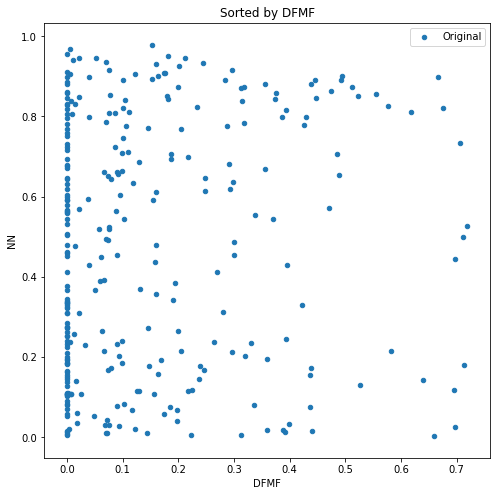

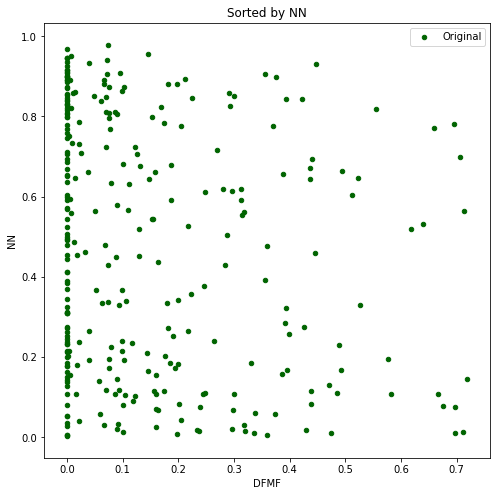

In [21]:
org_data = model.saved_cells_for_test[0]
predict_data = model.predict_test_cells[0]
data = []

# podatki urejenei po index
predict_data = sorted(predict_data, key=lambda l:l[0])
predict_cells = sorted(predict_cells, key=lambda l:l[0])

for j in range(len(org_data)):
    data.append([predict_cells[j][1], predict_data[j][1]])

data = sorted(data, key=lambda l:l[0])
# for j in range(len(data)):
#     data[j][1] = j
    
df = pd.DataFrame(data, columns=['DFMF', 'NN'])

fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot.scatter(x='DFMF', y='NN', label='Original', ax=ax);
ax.title.set_text('Sorted by DFMF')
# ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax);
# ax = df.plot.scatter(x='e', y='f', color='Yellow', label='DFMF', ax=ax);
# fig.savefig(path + 'scatter_org_vs_prediction_vs_DFMF' + str(i) + '.png')

org_data = model.saved_cells_for_test[0]
predict_data = model.predict_test_cells[0]
data = []
for j in range(len(org_data)):
    data.append([predict_cells[j][1], predict_data[j][1]])

data = sorted(data, key=lambda l:l[1])
# for j in range(len(data)):
#     data[j][0] = j
    
df = pd.DataFrame(data, columns=['DFMF', 'NN'])

fig, ax = plt.subplots(figsize=(8,8))
ax = df.plot.scatter(x='DFMF', y='NN', color='DarkGreen', label='Original', ax=ax);
ax.title.set_text('Sorted by NN')
# ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax);
# ax = df.plot.scatter(x='e', y='f', color='Yellow', label='DFMF', ax=ax);
# fig.savefig(path + 'scatter_org_vs_prediction_vs_DFMF' + str(i) + '.png')

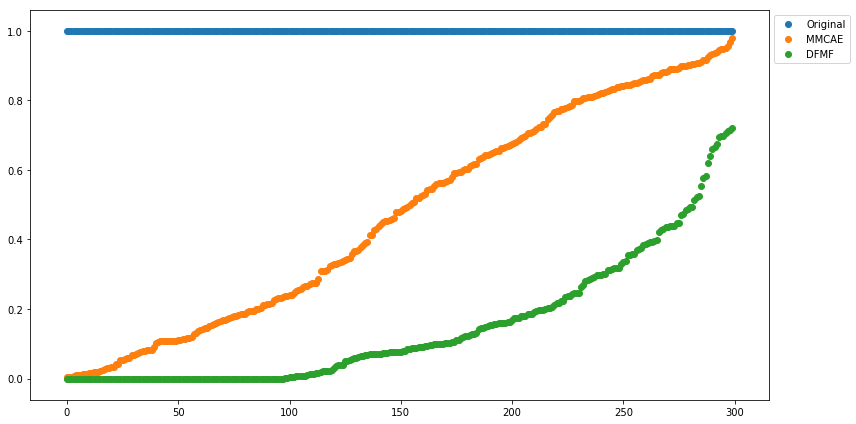

In [38]:
cols = ['Original', 'Prediction']
rows = ['Ann', 'Expr', 'PPI']
labels=['Empty', 'Full']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

for i in range(1):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_test_cells[i]
    data = []
    dfmf_predict = []
    for j in range(len(org_data)):
#         if i == 0:
#             if predict_data[j][1] > 0.1:
        data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        dfmf_predict.append([predict_cells[j][0], predict_cells[j][1]])

            
#     ax = axes[i]
    data = sorted(data, key=lambda l:l[3])
    dfmf_predict = sorted(dfmf_predict, key=lambda l:l[1])
    for j in range(len(data)):
        data[j][0] = j
        data[j][2] = j
        dfmf_predict[j][0] = j
        
    data = np.asarray(data)
    dfmf_predict = np.asarray(dfmf_predict)
    ax.scatter(data[:,0], data[:,1], label='Original')
    ax.scatter(data[:,2], data[:,3], label='MMCAE')
    ax.scatter(dfmf_predict[:,0], dfmf_predict[:,1], label='DFMF')
#     ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.legend(bbox_to_anchor=(1, 1.0))
    
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_ann_test_cells_org_vs_nn_vs_dfmf.png')
plt.show()

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)


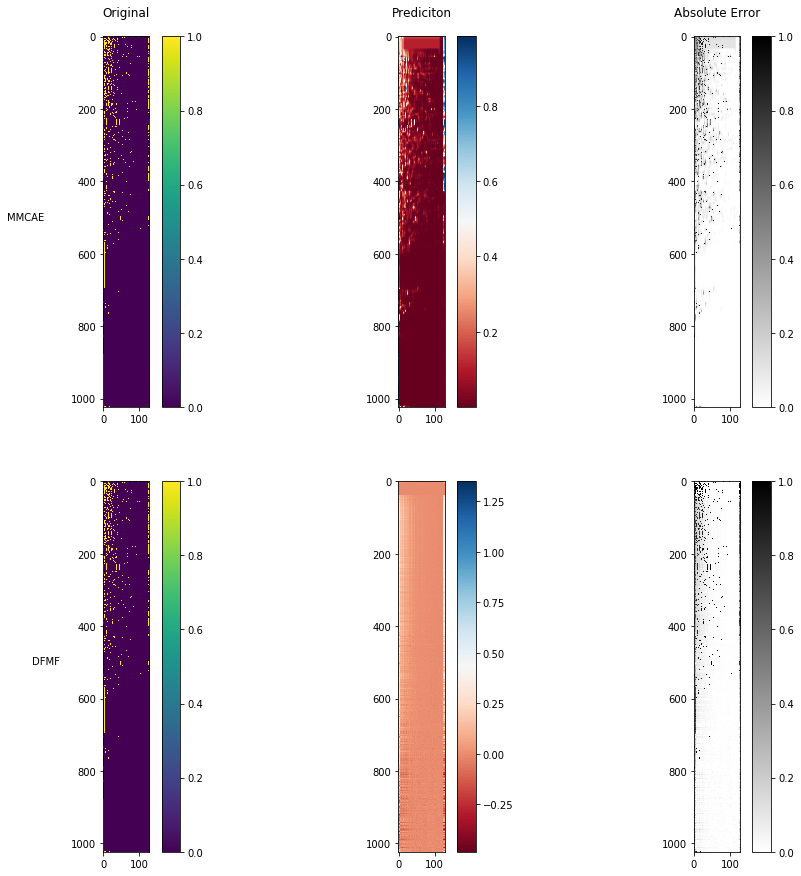

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
# color_pack2 = 'viridis'
color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;
    
    
cols = ['Original', 'Prediciton', 'Absolute Error']
rows = ['MMCAE', 'DFMF']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
    
for i in range(2):
    _, row, col, _ = model.org_data[0].shape
    org_data = model.org_data[0].reshape((row, col))
    predict = model.predict_data[0].reshape((row, col))

    if i == 1:
        predict = predict_DFMF


    ax = axes[i][0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))
#         ax.set_ylabel(rows[i], labelpad=25, rotation=0, size='large')
    if i == 0: 
        ax.set_title(cols[0], pad=20)
        ax.set_ylabel(rows[i], rotation=0, labelpad=45)
    else:
        ax.set_ylabel(rows[i], rotation=0, labelpad=25)

    ax = axes[i][1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))
    if i == 0: 
        ax.set_title(cols[1], pad=20)

    ax = axes[i][2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    if i == 0: 
        ax.set_title(cols[2], pad=20)
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[i][0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[i][1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[i][2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_ann_org_vs_nn_vs_dfmf.png')
plt.show()


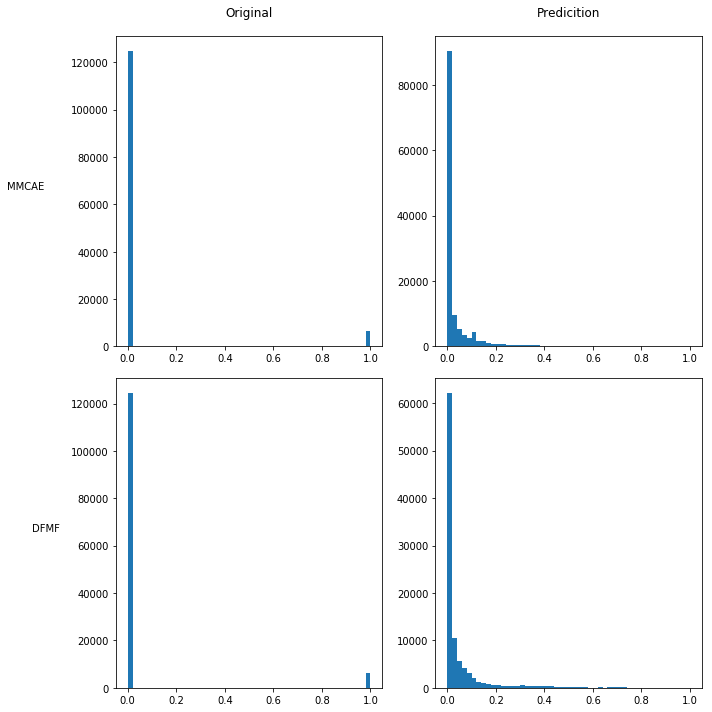

In [27]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['MMCAE', 'DFMF']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(2):
    org_data = model.org_data[0].flatten()
    pred_data = model.predict_data[0].flatten()
    if i == 1:
        pred_data = predict_DFMF.flatten()
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=False, range=(0,1))

#     ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0], pad=20)
        ax.set_ylabel(rows[i], rotation=0, labelpad=45)
    else:
        ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=False,range=(0,1))
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_ann_data_distribution_nn_vs_dfmf.png')
plt.show()

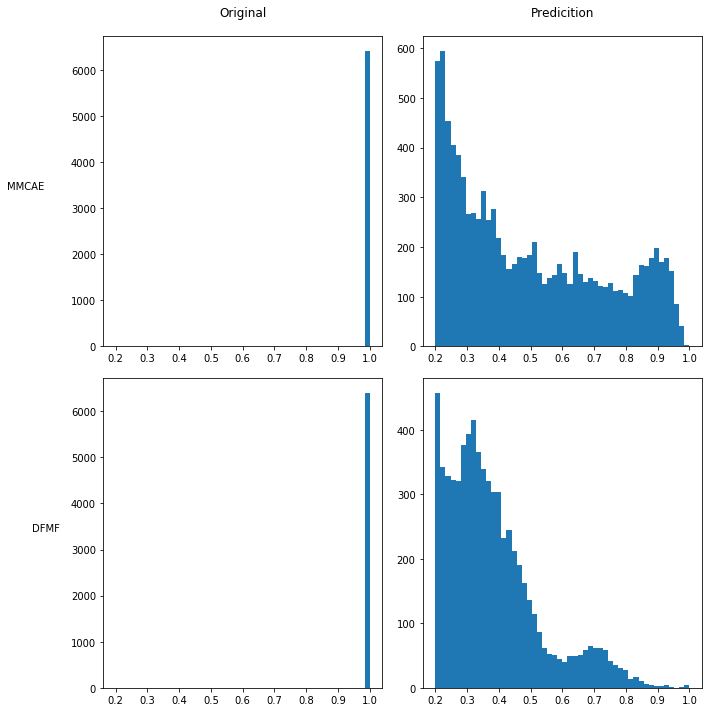

In [28]:
num_bins = 50
cols = ['Original', 'Predicition']
rows = ['MMCAE', 'DFMF']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
new_zero = 0.2

for i in range(2):
    org_data = model.org_data[0].flatten()
    pred_data = model.predict_data[0].flatten()
    if i == 1:
        pred_data = predict_DFMF.flatten()
        
    org_data = org_data[org_data > 0]
    pred_data = pred_data[pred_data >= new_zero]
    
    ax = axes[i][0]
    n, bins, patches = ax.hist(org_data, num_bins, density=False, range=(new_zero,1))
    
    if i == 0:
        ax.set_ylabel(rows[i], rotation=0, labelpad=45)
        ax.set_title(cols[0], pad=20)
    else:
        ax.set_ylabel(rows[i], rotation=0, labelpad=25)
        
    ax = axes[i][1]
# the histogram of the data
    n, bins, patches = ax.hist(pred_data, num_bins, density=False, range=(new_zero,1))
    if i == 0:
        ax.set_title(cols[1],pad=20)
    
    

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_ann_data_distribution_zoom_01_nn_vs_dfmf.png')
plt.show()

9865
6888


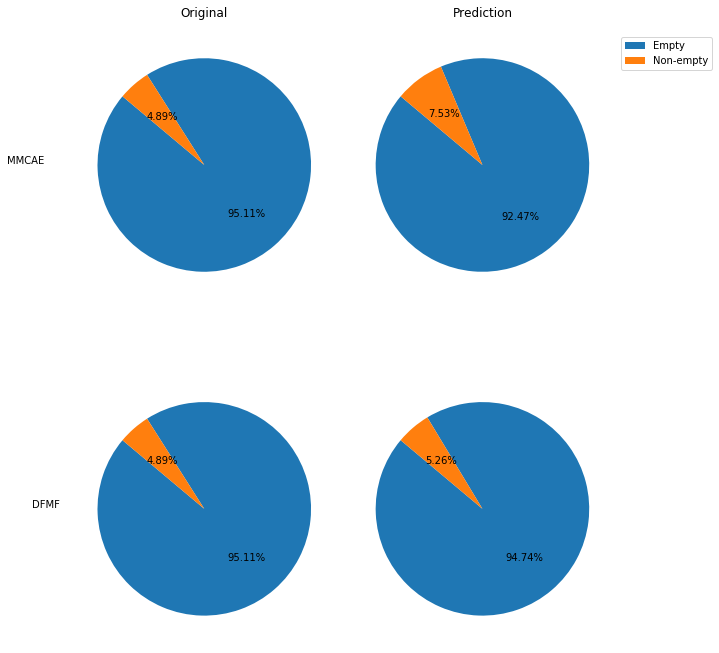

In [109]:
cols = ['Original', 'Prediction']
rows = ['MMCAE', 'DFMF']
labels=['Empty', 'Non-empty']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
new_zero = 0.2

for i in range(2):
    org_data = model.org_data[0].flatten()
    pred_data = model.predict_data[0].flatten()
    length = len(org_data)
    
    if i == 1:
        pred_data = predict_DFMF.flatten()
    
    org_data_zeros = org_data[org_data == 0]
    org_data_nonzeros = org_data[org_data > 0]
    
    pred_data_zeros = pred_data[pred_data < new_zero]
    pred_data_nonzeros = pred_data[pred_data >= new_zero]
    print(len(pred_data_nonzeros))
    
    ax = axes[i][0]
    ax.pie([len(org_data_zeros), len(org_data_nonzeros)], autopct='%1.2f%%', startangle=140)
#     ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    if i == 0:
        ax.set_title(cols[0],pad=15)
        ax.set_ylabel(rows[i], rotation=0, labelpad=45)
    else:
        ax.set_ylabel(rows[i], rotation=0, labelpad=25)
    
    
    ax = axes[i][1]
    ax.pie([len(pred_data_zeros), len(pred_data_nonzeros)], autopct='%1.2f%%', startangle=140)
    
    if i == 0:
        ax.set_title(cols[1],pad=15)
        ax.legend(bbox_to_anchor=(1, 1.0), labels=labels)
        
fig.tight_layout()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_ann_pie_chart_zoom_01_nn_vs_dfmf.png')
plt.show()

In [179]:
list_of_gens = []
gens = {}
predictio_gens = {}
dfmf_prediction_genes = {}
for i, data in enumerate(model.org_data):
    if i == 0:
        _, row, col, _ = data.shape
        data = data.reshape(row, col)
        test_data = model.saved_cells_for_test[i]
#         print(len(model.predict_validation_cells[i]))
#         print(len(model.predict_test_cells[i]))
#         print(model.predict_test_cells[i])
        for j, cell in enumerate(model.predict_test_cells[i]):
            gen = int(cell[0]/col) 
            gens[gen] = np.count_nonzero(data[gen])
            
            if gen not in predictio_gens:
                predictio_gens[gen] = [cell[1]]
            else:
                predictio_gens[gen].append(cell[1])
            
gens_name = {}
map_gene_name = {}
for obj in graph1.objects.values():        
    for relation in obj.relation_x:
        if relation.name == 'ann':
            for key in relation.x:
                if relation.x[key] in gens:
                    gens_name[key] = [key, np.count_nonzero(relation.matrix[relation.x[key]])]
                    map_gene_name[relation.x[key]] = key
       
    
for cell in predict_cells:
    for row in model.predict_test_cells[0]:
        if cell[0] == row[0]:
            gene = int(cell[0]/128)

            if gene not in dfmf_prediction_genes:
                dfmf_prediction_genes[gene] = [cell[1]]
            else:
                dfmf_prediction_genes[gene].append(cell[1])

for obj in graph1.objects.values():        
    for relation in obj.relation_x:
        if relation.name != 'ann':
            for key in relation.x:
                if key in gens_name:
                    gens_name[key].append(np.count_nonzero(relation.matrix[relation.x[key]]))


map_nonzero = []
map_gene_idx = {}
for key in gens:
#     print(str(map_gene_name[key]) + '\t' + str(gens_name[map_gene_name[key]]) + '\t' + str([format(x, '.5f') for x in predictio_gens[key]]) + '\t\t' + str([format(x, '.5f') for x in dfmf_prediction_genes[key]]))
    map_nonzero.append(gens_name[map_gene_name[key]])
    map_gene_idx[map_gene_name[key]] = key
    
map_nonzero = sorted(map_nonzero, key=lambda l:l[1], reverse=True)

genes_sum = []
NN_genes = []
DFMF_genes = []

for row in map_nonzero:
    key = map_gene_idx[row[0]]
    print(row[0] + '\t' + str(row[1:]) + '\t' + str([format(x, '.5f') for x in predictio_gens[key]]) + '\t\t' + str([format(x, '.5f') for x in dfmf_prediction_genes[key]]))
    genes_sum.append(np.sum(row[1:]))
    NN_genes.append(predictio_gens[key])
    DFMF_genes.append(dfmf_prediction_genes[key])

DDB_G0276221	[26, 256, 0]	['0.10793']		['0.00000']
DDB_G0285323	[26, 256, 0]	['0.26550']		['0.00297']
DDB_G0267414	[26, 250, 23]	['0.14648']		['0.00236']
DDB_G0276073	[24, 256, 77]	['0.42857', '0.34332']		['0.00002', '0.00001']
DDB_G0277855	[22, 256, 11]	['0.83195', '0.75890', '0.10793']		['0.00000', '0.00000', '0.00000']
DDB_G0288677	[22, 256, 10]	['0.10793', '0.10793']		['0.00000', '0.00000']
DDB_G0287153	[22, 256, 10]	['0.60336']		['0.00000']
DDB_G0279483	[21, 256, 25]	['0.25178']		['0.07883']
DDB_G0281827	[21, 256, 7]	['0.91050']		['0.31307']
DDB_G0276893	[20, 256, 0]	['0.49338', '0.11091']		['0.00000', '0.00000']
DDB_G0292574	[20, 256, 58]	['0.76843', '0.59275']		['0.29780', '0.21650']
DDB_G0273727	[20, 256, 77]	['0.66260']		['0.00000']
DDB_G0284331	[19, 254, 27]	['0.82153']		['0.00000']
DDB_G0273451	[19, 256, 21]	['0.84524']		['0.43902']
DDB_G0293476	[19, 256, 10]	['0.54336']		['0.16837']
DDB_G0268538	[19, 256, 19]	['0.58016']		['0.26328']
DDB_G0276947	[19, 256, 42]	['0.33359']		

1
422
42

3 0.07111322 0.012938468 0.94655776
3 0.2711589010392718 0.10982160570815336 0.28663953811025783

4 0.47233844 0.10792985 0.8732731
4 0.2449212187994951 3.2835996552864513e-13 0.5754558820500816

1 0.9083802 0.9083802 0.9083802
1 0.2693593525676716 0.2693593525676716 0.2693593525676716

2 0.42925808 0.106690414 0.75182575
2 0.26891641840947894 0.06330325404893125 0.47452958277002666

7 0.8612886 0.44528934 0.97879547
7 0.1490572093397369 0.042927320821870445 0.39597411909046754

159 0.42969072 0.0052942503 0.9447209
159 0.19774741103479976 -0.17785057435866594 0.9113755895709506

93 0.5619099 0.0032117867 0.9678313
93 0.18652286908168453 -0.017049801602526067 0.8475198080730877

25 0.5632032 0.009262564 0.9147549
25 0.09950412562366848 -0.027905928645816834 0.7466416214608318

5 0.17306751 0.033127986 0.4131188
5 0.12277972079946672 -0.005419212081687534 0.4332456746766634



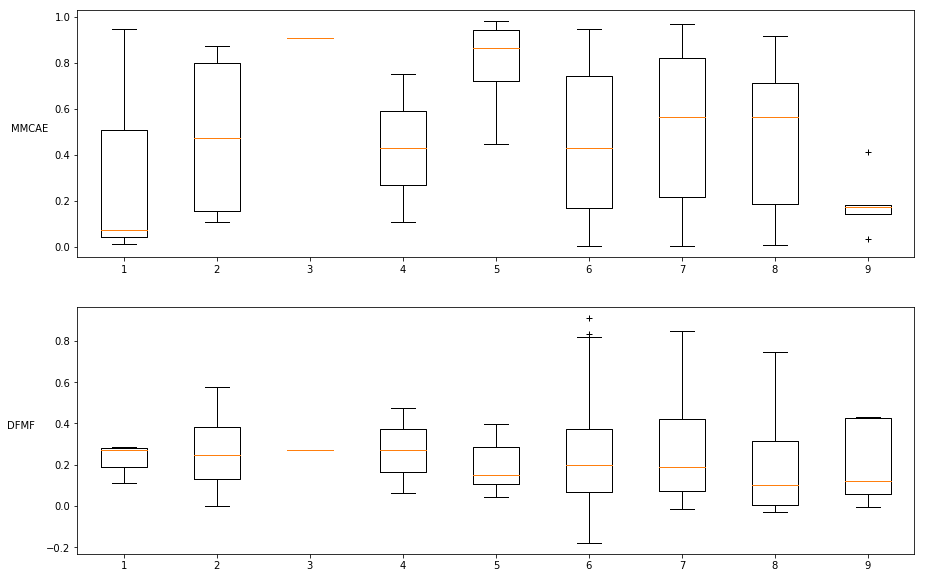

<Figure size 432x288 with 0 Axes>

In [193]:
rows = ['MMCAE', 'DFMF']
num_of_pieces = 10

# genes_sum = sorted(genes_sum)
print(np.min(genes_sum))
print(np.max(genes_sum))
piece = int((np.max(genes_sum) - np.min(genes_sum))/num_of_pieces)
print(piece)
print()

MMCAE = {}
DFMF = {}
list_of_data_MMCAE = []
list_of_data_DFMF = []
MMCAE_median = []
DFMF_median = []

# l = np.array_split(genes_sum, 10)
for i, value in enumerate(genes_sum):
    idx = int(value/piece)
    if idx not in MMCAE:
        MMCAE[idx] = NN_genes[i]
        DFMF[idx] = DFMF_genes[i]
    else:
        MMCAE[idx] = MMCAE[idx] + NN_genes[i]
        DFMF[idx] = DFMF[idx] + DFMF_genes[i]
    
for key in range(len(MMCAE)):
    if key not in MMCAE:
        continue
        
    print(len(MMCAE[key]), np.median(MMCAE[key]), np.min(MMCAE[key]), np.max(MMCAE[key]))
    print(len(DFMF[key]), np.median(DFMF[key]), np.min(DFMF[key]), np.max(DFMF[key]) )
    print()
    list_of_data_MMCAE.append(MMCAE[key])
    list_of_data_DFMF.append(DFMF[key])
    
    MMCAE_median.append(np.median(MMCAE[key]))
    DFMF_median.append(np.median(DFMF[key]))
    
fig, axes = plt.subplots(2,1, figsize=(15, 10))
ax = axes[0]
# pos = [np.abs(i - num_of_pieces) for i in range(1, len(list_of_data_MMCAE)+1)]
pos = range(1, len(list_of_data_MMCAE)+1)
bp = ax.boxplot(list_of_data_MMCAE, sym='k+', positions=pos,
                notch=0, usermedians=MMCAE_median)
ax.set_ylabel(rows[0], rotation=0, labelpad=25)

ax = axes[1]
bp = ax.boxplot(list_of_data_DFMF, sym='k+', positions=pos,
                notch=0, usermedians=DFMF_median)
ax.set_ylabel(rows[1], rotation=0, labelpad=25)

plt.show()
plt.savefig(path + 'experiment_' + str(numOfExperiment) + '_ann_box_plot_nn_vs_dfmf.png')